# Основной блок

**Постановка задачи**: Фотографии загружаемые поставщиками WB имеют разное качество: На одних может быть сложный фон, на каких-то фотографиях часть объекта не попала в кадр и.т.п. Для последующей работы с такими данными, например при использовании алгоритмов поиска по фото надо знать типs дефектов/овособенностей которые присутствуют на изображении.

<img src ="https://ml.gan4x4.ru/wb/quality/content/samples.png" width="800">


Всего 6 типов особенностей:  

* untidy,
* angle-composition,
* background,
* crop,
* text,
* multiple-objects

и один класс для изображений без дефектов
* good-image.

При этом изображение может содержать несколько видов дефектов.


Задача:

Требуется создать модель которая будет определять список дефектов для для изображения.

**Данные**

По [ссылке](https://ml.gan4x4.ru/wb/quality/5000/student_5000.zip) доступен архив содержащий 5000 изображений и разметку.

Оригинальные изображения имели размер 900x1200 в датасете их разрешение уменьшено вдвое. Кроме изображений в архиве находиться csv файл c разметкой.
В первой колонке имя файла с изображением (без расширения), в остальных колонках названия классов к которым относиться изображение:

```
  18715,text,multiple-objects,,
  5259,text,background,,
  8932,background,,,
  ...

```

**Порядок выполнения задания**

Задание рекомендуется выполнять по шагам:

1. Познакомьтесь с данными
2. Выберите метрику для оценки результата
3. Проведите анализ состояния вопроса, изучите существующие модели которые можно использовать для решения задачи
4. Проведите EDA, опишите особенности данных и проблемы которые они могут за собой повлечь
5. Подготовьте данные для обучения
6. Выберите baseline модель, оцените качество её работы на данном датасете.
7. Попробуйте улучшить значение метрики используя другую модель. Возможно обучив/дообучив ее.
8. Оцените быстродействие выбранной модели
9. Дайте оценку полученному результату.


**Важно!**

Блокнот должен содержать весь необходимый код для запуска финальной модели. Если для запуска требуется подгрузка весов, все ссылки длжны работать не только в вашем аккаунте но и в аккаунте преподавателя.

In [ ]:
#@title requirements.txt

!pip install pytorch-lightning
!pip install efficientnet_pytorch
!pip install imbalanced-learn
!pip install optuna
!pip install opencv-python
!pip install wget
!pip install scikit-multilearn

In [ ]:
#@title Импорт библиотек

import os
import pandas as pd
import numpy as np
import wget
import zipfile

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, hamming_loss, roc_curve, auc

from efficientnet_pytorch import EfficientNet
import cv2

import optuna
from optuna.integration import PyTorchLightningPruningCallback

import matplotlib.pyplot as plt
import seaborn as sns
import random

c:\Users\Dire-foxy\Programming\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#@title Глобальные параметры

DATA_URL = "https://ml.gan4x4.ru/wb/quality/5000/student_5000.zip"
DATA_DIR = "5000"
IMAGE_DIR = os.path.join(DATA_DIR, "5000", "images")
images_dir = "C:/Users/Dire-foxy/Programming/EX2_WB_test/5000/5000/images"

# Определяем классы дефектов (без 'good-image')
CLASSES = ['untidy', 'angle-composition', 'background', 'crop', 'text', 'multiple-objects']
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('medium')
N_TRIALS = 3  # Количество запусков Optuna
EPOCHS = 15

In [ ]:
#@title Функции

def load_data():
    """Загружает и предобрабатывает данные."""
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR, exist_ok=True)
        wget.download(DATA_URL, out=DATA_DIR)

        with zipfile.ZipFile(os.path.join(DATA_DIR, 'student_5000.zip'), 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)

    df = pd.read_csv(os.path.join(DATA_DIR, "5000", "5000.csv"), header=None)
    df.columns = ['image_id', 'defect1', 'defect2', 'defect3', 'defect4']

    # Добавляем 'good-image' только если нет других меток
    df['defects'] = df.apply(
        lambda row: [d for d in row[1:] if isinstance(d, str)] or ['good-image'],
        axis=1
    )

    # One-Hot Encoding для дефектов (без 'good-image')
    for defect in CLASSES:
        df[defect] = df['defects'].apply(lambda x: 1 if defect in x else 0)

    # Разделяем на признаки (X) и метки (y)
    X = df['image_id']
    y = df[CLASSES]  # Метки - только дефекты

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test


def visualize_images(image_ids, labels, image_dir, num_images=5):

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        idx = random.randint(0, len(image_ids) - 1)
        img_id = image_ids.iloc[idx]
        img_path = os.path.join(image_dir, str(img_id) + '.jpg')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)

        # Измененный код:
        classes = [CLASSES[j] for j in range(len(CLASSES)) if labels.iloc[idx, j] == 1]
        if not classes:  # Если список классов пуст
            classes = ['good-image']  # Добавляем 'good-image'

        plt.title(f"ID: {img_id}\nClasses: {', '.join(classes)}")
        plt.axis('off')
    plt.show()

def plot_class_distribution(y_train):

    plt.figure(figsize=(10, 5))
    counts = y_train.sum(axis=0)
    plt.bar(CLASSES, counts)
    plt.xticks(np.arange(len(CLASSES)), CLASSES, rotation=45, ha='right')
    plt.title('Распределение классов в обучающей выборке')
    plt.xlabel('Классы')
    plt.ylabel('Количество изображений')
    plt.show()


class ImageQualityDataset(Dataset):
    # Датасет с изображениями и метками
    def __init__(self, image_ids, labels, image_dir, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, str(self.image_ids.iloc[idx]) + '.jpg')
        label = torch.tensor(self.labels.iloc[idx].values.astype(float))
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label


class ImageQualityModule(pl.LightningModule):
  # PyTorch Lightning
    def __init__(self, lr=1e-3, gamma=2.0, class_weights=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = EfficientNet.from_pretrained('efficientnet-b4')
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Linear(num_ftrs, len(CLASSES))
        self.class_weights = class_weights.to(
            DEVICE) if class_weights is not None else None
        self.criterion = nn.BCEWithLogitsLoss()
        self.test_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('test_loss', loss)

        probs = torch.sigmoid(outputs)

        threshold = 0.7
        preds = (probs > threshold).float()

        self.test_outputs.append({'loss': loss, 'preds': preds, 'labels': labels, 'probs': probs})
        return {'loss': loss, 'preds': preds, 'labels': labels, 'probs': probs}


    def on_test_epoch_end(self):

        # Подсчет и вывод метрик
        all_preds = torch.cat([x['preds'] for x in self.test_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_outputs])
        all_probs = torch.cat([x['probs'] for x in self.test_outputs])


        accuracy = accuracy_score(all_labels.cpu(), all_preds.cpu())
        precision = precision_score(all_labels.cpu(), all_preds.cpu(), average=None)
        recall = recall_score(all_labels.cpu(), all_preds.cpu(), average=None)
        f1 = f1_score(all_labels.cpu(), all_preds.cpu(), average=None)
        roc_auc = roc_auc_score(all_labels.cpu(), all_probs.cpu(), average='macro', multi_class='ovr')
        test_loss = self.criterion(all_preds, all_labels).item()

        hamming_loss_value = hamming_loss(all_labels.cpu(), all_preds.cpu())
        print(f"Hamming Loss: {hamming_loss_value:.4f}")

        # Micro-F1
        micro_f1 = f1_score(all_labels.cpu(), all_preds.cpu(), average='micro')
        print(f"Micro-F1: {micro_f1:.4f}")

        # Macro-F1
        macro_f1 = f1_score(all_labels.cpu(), all_preds.cpu(), average='macro')
        print(f"Macro-F1: {macro_f1:.4f}")

        # Вывод общих метрик
        print("──────────────────────────────")
        print("Тестовые метрики")
        print("──────────────────────────────")
        print(f"Точность (Accuracy): {accuracy:.4f}")
        print(f"Потери (Loss): {test_loss:.4f}")
        print(f"AUC-ROC: {roc_auc:.4f}")
        print("──────────────────────────────")

        # Вывод метрик по классам
        print("──────────────────────────────")
        print("Метрики по классам")
        print("──────────────────────────────")
        for i, cls in enumerate(CLASSES):
            print(f"{cls}:")
            print(f"  Точность (Precision): {float(precision[i]):.4f}")
            print(f"  Полнота (Recall): {float(recall[i]):.4f}")
            print(f"  F1-мера (F1-score): {float(f1[i]):.4f}")
        print("──────────────────────────────")

        # Confusion matrix
        cm = confusion_matrix(all_labels.cpu().argmax(dim=1), all_preds.cpu().argmax(dim=1))

        # Plot confusion matrix
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=CLASSES, yticklabels=CLASSES)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        # Подсчет ROC кривых
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(CLASSES)):
            fpr[i], tpr[i], _ = roc_curve(all_labels.cpu()[:, i], all_probs.cpu()[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC кривых
        plt.figure(figsize=(10, 10))
        for i in range(len(CLASSES)):
            plt.plot(fpr[i], tpr[i], label=f'{CLASSES[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.legend(loc="lower right")
        plt.show()

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        return optimizer


def objective(trial):
    # Функция для Optuna, которая создает, обучает и оценивает модель

    # 1. Гиперпараметры для Optuna
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 1.0, 3.0)
    threshold = trial.suggest_float("threshold", 0.5, 0.9)

    # Преобразование class_weights в тензор PyTorch
    class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float).to(DEVICE)

    # 2. Создание модели с текущими гиперпараметрами
    model = ImageQualityModule(lr=lr, gamma=gamma, class_weights=class_weights_tensor)

    # 3. Создание объекта Trainer
    trainer = pl.Trainer(
        logger=True,  # Логирование
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=3),
            PyTorchLightningPruningCallback(trial, monitor="val_loss"),  # Интеграция с Optuna
            ModelCheckpoint(  # Сохранение лучшей модели
                monitor='val_loss',
                dirpath='./checkpoints',
                filename='image_quality-{epoch:02d}-{val_loss:.2f}',
                save_top_k=1,
                mode='min'
            )
        ],
        max_epochs=EPOCHS,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1 if torch.cuda.is_available() else None,
        precision=16 if torch.cuda.is_available() else 32,
    )

    # 4. Обучение модели
    trainer.fit(model, train_loader, val_loader)

    # 5. Возвращаем метрику для Optuna (в данном случае val_loss)
    return trainer.callback_metrics["val_loss"].item()

In [ ]:
#@title Загрузка и подготовка данных

X_train, X_val, X_test, y_train, y_val, y_test = load_data()
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAdjustSharpness(sharpness_factor=0.5),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
}

train_dataset = ImageQualityDataset(X_train, y_train, images_dir, transform=data_transforms['train'])
val_dataset = ImageQualityDataset(X_val, y_val, images_dir, transform=data_transforms['val'])
test_dataset = ImageQualityDataset(X_test, y_test, images_dir, transform=data_transforms['test'])

In [ ]:
#@title Создание WeightedRandomSampler

# 1. Подсчет весов для каждого класса
class_counts = y_train.sum(axis=0)
class_weights = 1. / class_counts
sample_weights = [class_weights[i] for i in y_train.values.argmax(axis=1)]

# 2. Создание WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(y_train), replacement=True)

# 3. Создание DataLoader с WeightedRandomSampler
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

C:\Users\Dire-foxy\AppData\Local\Temp\ipykernel_5048\3678917961.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weights = [class_weights[i] for i in y_train.values.argmax(axis=1)]


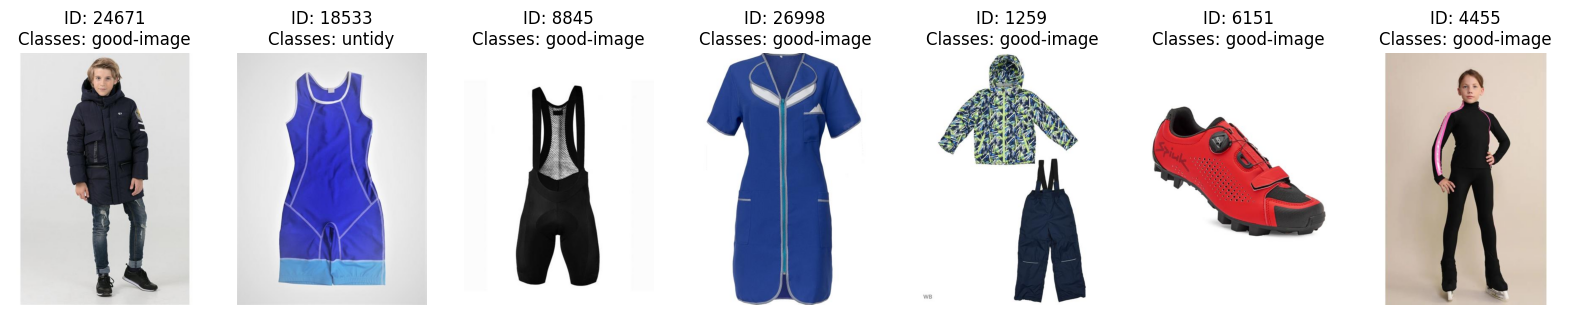

In [ ]:
visualize_images(X_train, y_train, images_dir, num_images=7)

**Проблемы в данном случае могут возникать из за классов *crop*, *background*  
так как отсекаются некоторые способы аугментации.**

**Так же на мой взгляд разметка в датасете сильно хромает, так как даже беглым взлядом можно оценить что класс *good-image* содержит некоторые дефекты**

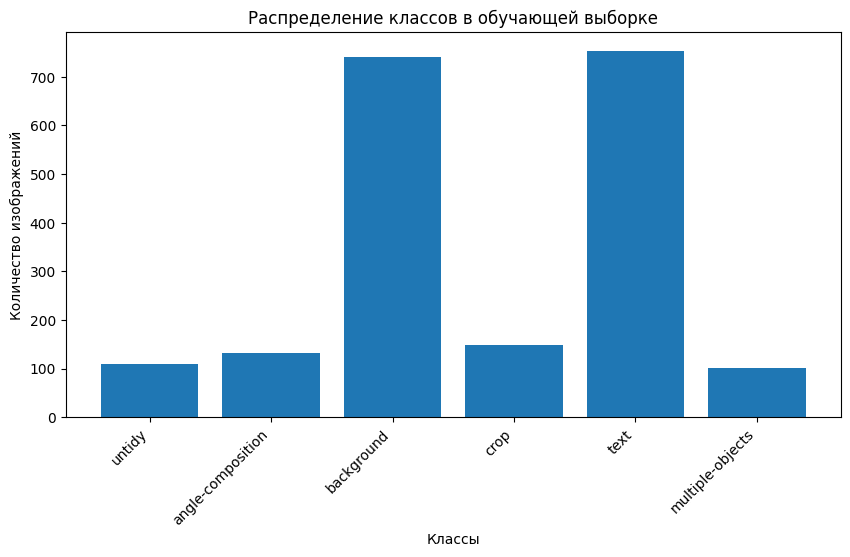

In [ ]:
plot_class_distribution(y_train)

**background и text сильно превосходят остальные классы, из-за чего будет более низкая точность на минорных классах, по этому хорошим выбором будет балансировка классов путем выравнивания весов**

In [ ]:
#@title Перебор гиперпараметров с помощью Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-08 01:29:49,682] A new study created in memory with name: no-name-235c4858-04c1-416b-9375-b91b276cfcf8
c:\Users\Dire-foxy\Programming\.venv\lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loaded pretrained weights for efficientnet-b4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | EfficientNet      | 17.6 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
17.6 M    Trainable params
0         Non-trainable params
17.6 M    Total params
70.237    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Dire-foxy\Programming\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\Dire-foxy\Programming\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s, v_num=0]


[I 2024-07-08 01:35:31,999] Trial 0 finished with value: 0.0999237269705086 and parameters: {'lr': 0.0002850213339323247, 'gamma': 1.9591654764134048, 'threshold': 0.5460964982740968}. Best is trial 0 with value: 0.0999237269705086.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Dire-foxy\Programming\.venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\Dire-foxy\Programming\EX2_WB_test\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | EfficientNet      | 17.6 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
17.6 M    Trainable params
0         Non-trainable params
17.6 M    Total params
70.237 

Loaded pretrained weights for efficientnet-b4
Epoch 9: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s, v_num=1]        


[I 2024-07-08 01:44:59,027] Trial 1 finished with value: 0.08588164396355084 and parameters: {'lr': 0.00010967671553360714, 'gamma': 1.4747563861123631, 'threshold': 0.5869333147210828}. Best is trial 1 with value: 0.08588164396355084.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | EfficientNet      | 17.6 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
17.6 M    Trainable params
0         Non-trainable params
17.6 M    Total params
70.237    Total estimated model params size (MB)


Loaded pretrained weights for efficientnet-b4
Epoch 8: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s, v_num=2]        


[I 2024-07-08 01:53:27,727] Trial 2 finished with value: 0.08635425398944882 and parameters: {'lr': 0.00011809983519799237, 'gamma': 2.6631983421452237, 'threshold': 0.5612663668202679}. Best is trial 1 with value: 0.08588164396355084.


Number of finished trials: 3
Best trial:
  Value: 0.08588164396355084
  Params: 
    lr: 0.00010967671553360714
    gamma: 1.4747563861123631
    threshold: 0.5869333147210828


**На графиках видно как обучались 3 итерации модели с разными гиперпараметрами:**

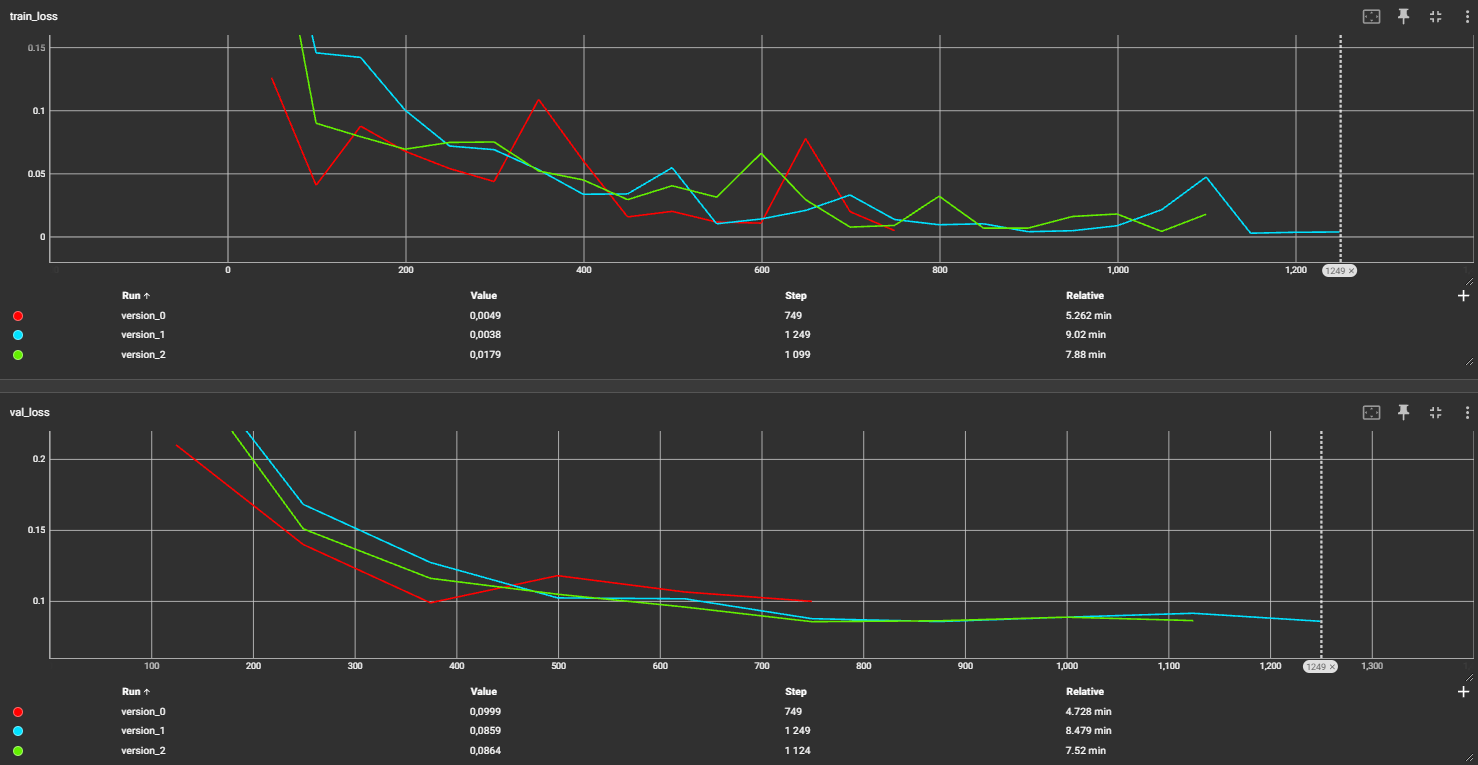

**Самый лучший результат показала 3 итерация (зеленая ветка), достигнув наименьших потерь на 5 эпохе.**

Loaded pretrained weights for efficientnet-b4


c:\Users\Dire-foxy\Programming\.venv\lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Dire-foxy\Programming\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  5.16it/s]Hamming Loss: 0.0277
Micro-F1: 0.8047
Macro-F1: 0.6606
──────────────────────────────
Тестовые метрики
──────────────────────────────
Точность (Accuracy): 0.8580
Потери (Loss): 0.6746
AUC-ROC: 0.9593
──────────────────────────────
──────────────────────────────
Метрики по классам
──────────────────────────────
untidy:
  Точность (Precision): 0.6875
  Полнота (Recall): 0.9167
  F1-мера (F1-score): 0.7857
angle-composition:
  Точность (Precision): 0.7500
  Полнота (Recall): 0.2500
  F1-мера (F1-score): 0.3750
background:
  Точность (Precision): 0.9180
  Полнота (Recall): 0.7000
  F1-мера (F1-score): 0.7943
crop:
  Точность (Precision): 0.7273
  Полнота (Recall): 0.3077
  F1-мера (F1-score): 0.4324
text:
  Точность (Precision): 0.9884
  Полнота (Recall): 0.9341
  F1-мера (F1-score): 0.9605
multiple-objects:
  Точность (Precision): 1.0000
  Полнота (Recall): 0.4444
  F1-мера (F1-score): 0.6154
────────────────────────────

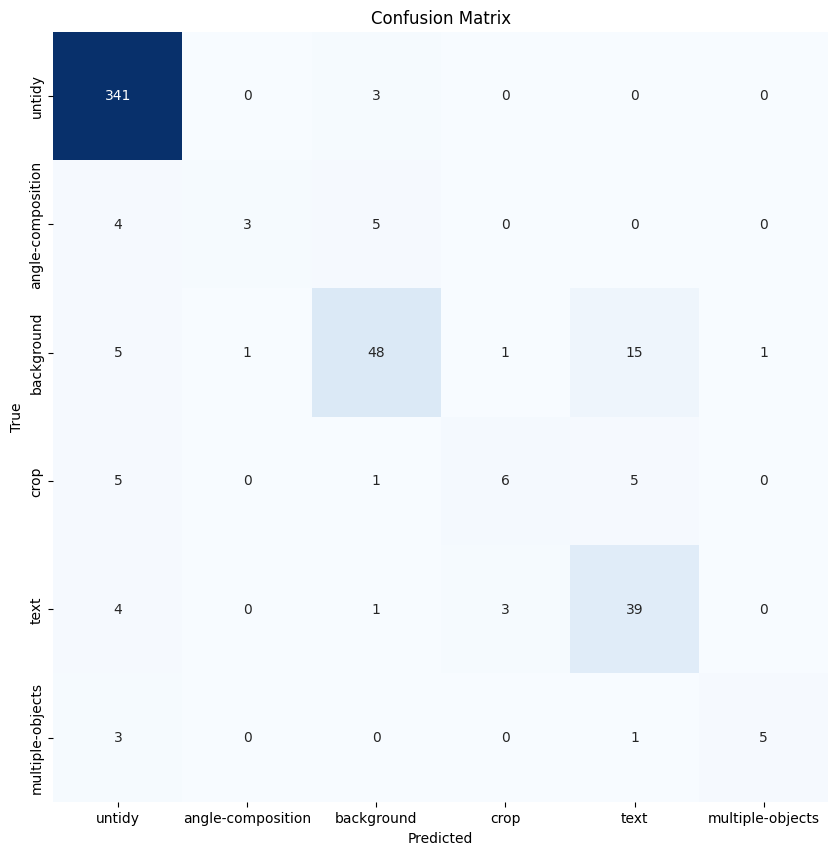

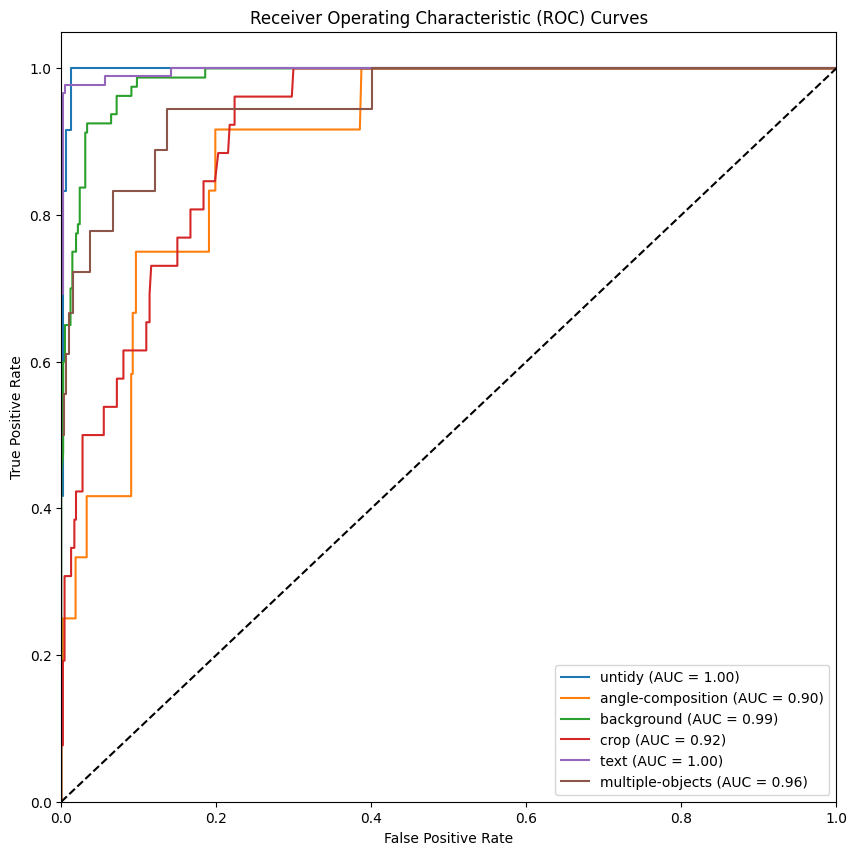

Testing DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.08415331807304754
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.08415331807304754}]

In [ ]:
#@title Оценка лучшей модели

checkpoint_path = "C:/Users/Dire-foxy/Programming/EX2_WB_test/checkpoints/image_quality-epoch=05-val_loss=0.09.ckpt"

best_model = ImageQualityModule.load_from_checkpoint(checkpoint_path=checkpoint_path)

best_trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    precision=16 if torch.cuda.is_available() else 32,
)


best_trainer.test(best_model, test_loader)

**Вывод по результатам обучения и тестирования модели**

**Обучение:**

- Модель была обучена с использованием фреймворка PyTorch Lightning и EfficientNet-b4 в качестве базовой архитектуры.

- Для борьбы с дисбалансом классов был применен метод WeightedRandomSampler, который увеличивает вероятность выбора примеров из минорных классов во время обучения.

- Гиперпараметры модели были оптимизированы с помощью библиотеки Optuna, которая провела 3 запуска с различными комбинациями значений.

**Результаты тестирования:**

- Общая точность (Accuracy): 0.8580 - модель правильно классифицировала 85.8% изображений в тестовом наборе.

- Потери (Loss): 0.6746 - среднее значение функции потерь на тестовом наборе.

- AUC-ROC: 0.9593 - этот показатель, усредненный по всем классам, указывает на очень хорошую способность модели различать классы.

- Hamming Loss: 0.0277 - средняя доля неправильно предсказанных меток, что свидетельствует о низком уровне ошибок.

- Micro-F1: 0.8047 - усредненная F1-мера по всем классам с учетом количества элементов в каждом классе.

- Macro-F1: 0.6606 - усредненная F1-мера по всем классам без учета дисбаланса классов.

**Анализ метрик по классам:**

- Модель демонстрирует высокую производительность для классов text и background с показателями F1-меры выше 0.9. Класс untidy также показывает хороший результат с F1-мерой 0.7857.

- Классы angle-composition, crop и multiple-objects имеют более низкие показатели F1-меры, что может быть связано с меньшим количеством примеров этих классов в обучающем наборе.

- ROC-кривые для всех классов показывают, что модель хорошо разделяет классы, что подтверждается высокими значениями AUC.

**Выводы:**

- Модель демонстрирует хорошие результаты в задаче многометочной классификации изображений.

- Применение WeightedRandomSampler помогло улучшить производительность модели на минорных классах.


# Тестовый блок для проверки

Поместите сюда весь необходимый код для тестирования вашей модели на новых данных. Убедитесь что

- Импортируются все библиотеки и классы
- Подгружаются веса с внешних ресурсов
- Происходит рассчет метрик
...

## Если есть метки:

In [ ]:
#@title requirements.txt

!pip install efficientnet_pytorch wget pytorch_lightning

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 19.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-man

In [ ]:
#@title Импорт библиотек

import os
import wget
import zipfile
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, hamming_loss, roc_curve, auc
import pytorch_lightning as pl
import requests
import random

In [ ]:
#@title Глобальные параметры

MODEL_URL = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/iy45_PHU_Aaglg'
MODEL_PATH = "image_quality-epoch=05-val_loss=0.09.ckpt"

DATA_URL = "https://ml.gan4x4.ru/wb/quality/5000/student_5000.zip" # ВСТАВЬТЕ ВАШУ ССЫЛКУ СЮДА!
ZIP_NAME = "student_5000.zip" # НЕОБХОДИМО ПРОПИСАТЬ ТОЧНОЕ НАИМЕНОВАНИЕ ZIP ФАЙЛА

DATA_DIR = "WB_Images"

IMAGE_DIR = os.path.join(DATA_DIR, "5000", "images") # ТУТ НЕОБХОДИМО НАПИСАТЬ ПУТЬ К ИЗОБРАЖЕНИЯМ
LABELS_DIR = os.path.join(DATA_DIR, "5000", "5000.csv") # ТУТ НЕОБХОДИМО НАПИСАТЬ ПУТЬ К МЕТКАМ

CLASSES = ['untidy', 'angle-composition', 'background', 'crop', 'text', 'multiple-objects']
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title Функции

class ImageQualityDataset(Dataset):
    def __init__(self, image_ids, image_dir, transform=None):
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, str(self.image_ids.iloc[idx]) + '.jpg')
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor([0])  # Возвращаем фиктивную метку

class ImageQualityModule(pl.LightningModule):
    def __init__(self, num_classes=len(CLASSES)):
        super(ImageQualityModule, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b4')
        num_ftrs = self.model._fc.in_features
        self.model._fc = torch.nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.BCEWithLogitsLoss()(outputs, labels.float())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.BCEWithLogitsLoss()(outputs, labels.float())
        self.log("val_loss", loss)
        return loss

# Функция для загрузки и распаковки данных
def load_data():
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR, exist_ok=True)
    wget.download(DATA_URL, out=DATA_DIR)

    with zipfile.ZipFile(
        os.path.join(DATA_DIR, ZIP_NAME),
        'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

    df = pd.read_csv(os.path.join(LABELS_DIR), header=None)
    df.columns = ['image_id', 'defect1', 'defect2', 'defect3', 'defect4']
    df['defects'] = df.apply(
        lambda row: [d for d in row[1:] if isinstance(d, str)] or ['good-image'],
        axis=1
    )
    for defect in CLASSES:
        df[defect] = df['defects'].apply(lambda x: 1 if defect in x else 0)
    return df[['image_id'] + CLASSES]  # Возвращаем DataFrame с ID изображений и метками

In [ ]:
#@title Загрузка данных

df = load_data()
test_image_ids = df['image_id']
test_labels = df[CLASSES]

# Преобразования
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
#@title Датасет и DataLoader

test_dataset = ImageQualityDataset(test_image_ids, IMAGE_DIR, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#@title Загрузка модели

# Отправляем GET-запрос и получаем ответ
response = requests.get(MODEL_URL, stream=True)

# Проверяем статус ответа
if response.status_code == 200:
    # Открываем файл для записи
    with open(MODEL_PATH, 'wb') as file:
        # Читаем ответ по частям и записываем в файл
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
else:
    print(f"Ошибка при скачивании: {response.status_code}")

print(f"Файл успешно скачан и сохранен в {MODEL_PATH}")

checkpoint_path = MODEL_PATH

best_model = ImageQualityModule.load_from_checkpoint(checkpoint_path=checkpoint_path)
best_model.eval()

Файл успешно скачан и сохранен в image_quality-epoch=05-val_loss=0.09.ckpt
Loaded pretrained weights for efficientnet-b4


ImageQualityModule(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSame

In [ ]:
#@title Тестирование модели

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(DEVICE)
        outputs = best_model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        all_preds.append(preds)
        all_probs.append(probs)

all_preds = torch.cat(all_preds).cpu().numpy()
all_probs = torch.cat(all_probs).cpu().numpy()
all_labels = test_labels.values

In [ ]:
#@title Метрики

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)
f1 = f1_score(all_labels, all_preds, average=None)
roc_auc = roc_auc_score(all_labels, all_probs, average='macro', multi_class='ovr')
hamming_loss_value = hamming_loss(all_labels, all_preds)

In [ ]:
#@title Вывод метрик

print("-" * 30)
print("Результаты тестирования:")
print("-" * 30)
print(f"Hamming Loss: {hamming_loss_value:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("-" * 30)
print("Метрики по классам:")
print("-" * 30)
for i, cls in enumerate(CLASSES):
    print(f"{cls}:")
    print(f" Precision: {precision[i]:.4f}")
    print(f" Recall: {recall[i]:.4f}")
    print(f" F1-score: {f1[i]:.4f}")

------------------------------
Результаты тестирования:
------------------------------
Hamming Loss: 0.0150
Accuracy: 0.9210
AUC-ROC: 0.9881
------------------------------
Метрики по классам:
------------------------------
untidy:
 Precision: 0.8671
 Recall: 1.0000
 F1-score: 0.9288
angle-composition:
 Precision: 0.7444
 Recall: 0.8171
 F1-score: 0.7791
background:
 Precision: 0.9570
 Recall: 0.8486
 F1-score: 0.8995
crop:
 Precision: 0.8176
 Recall: 0.7165
 F1-score: 0.7637
text:
 Precision: 0.9957
 Recall: 0.9572
 F1-score: 0.9761
multiple-objects:
 Precision: 0.9574
 Recall: 0.6767
 F1-score: 0.7930


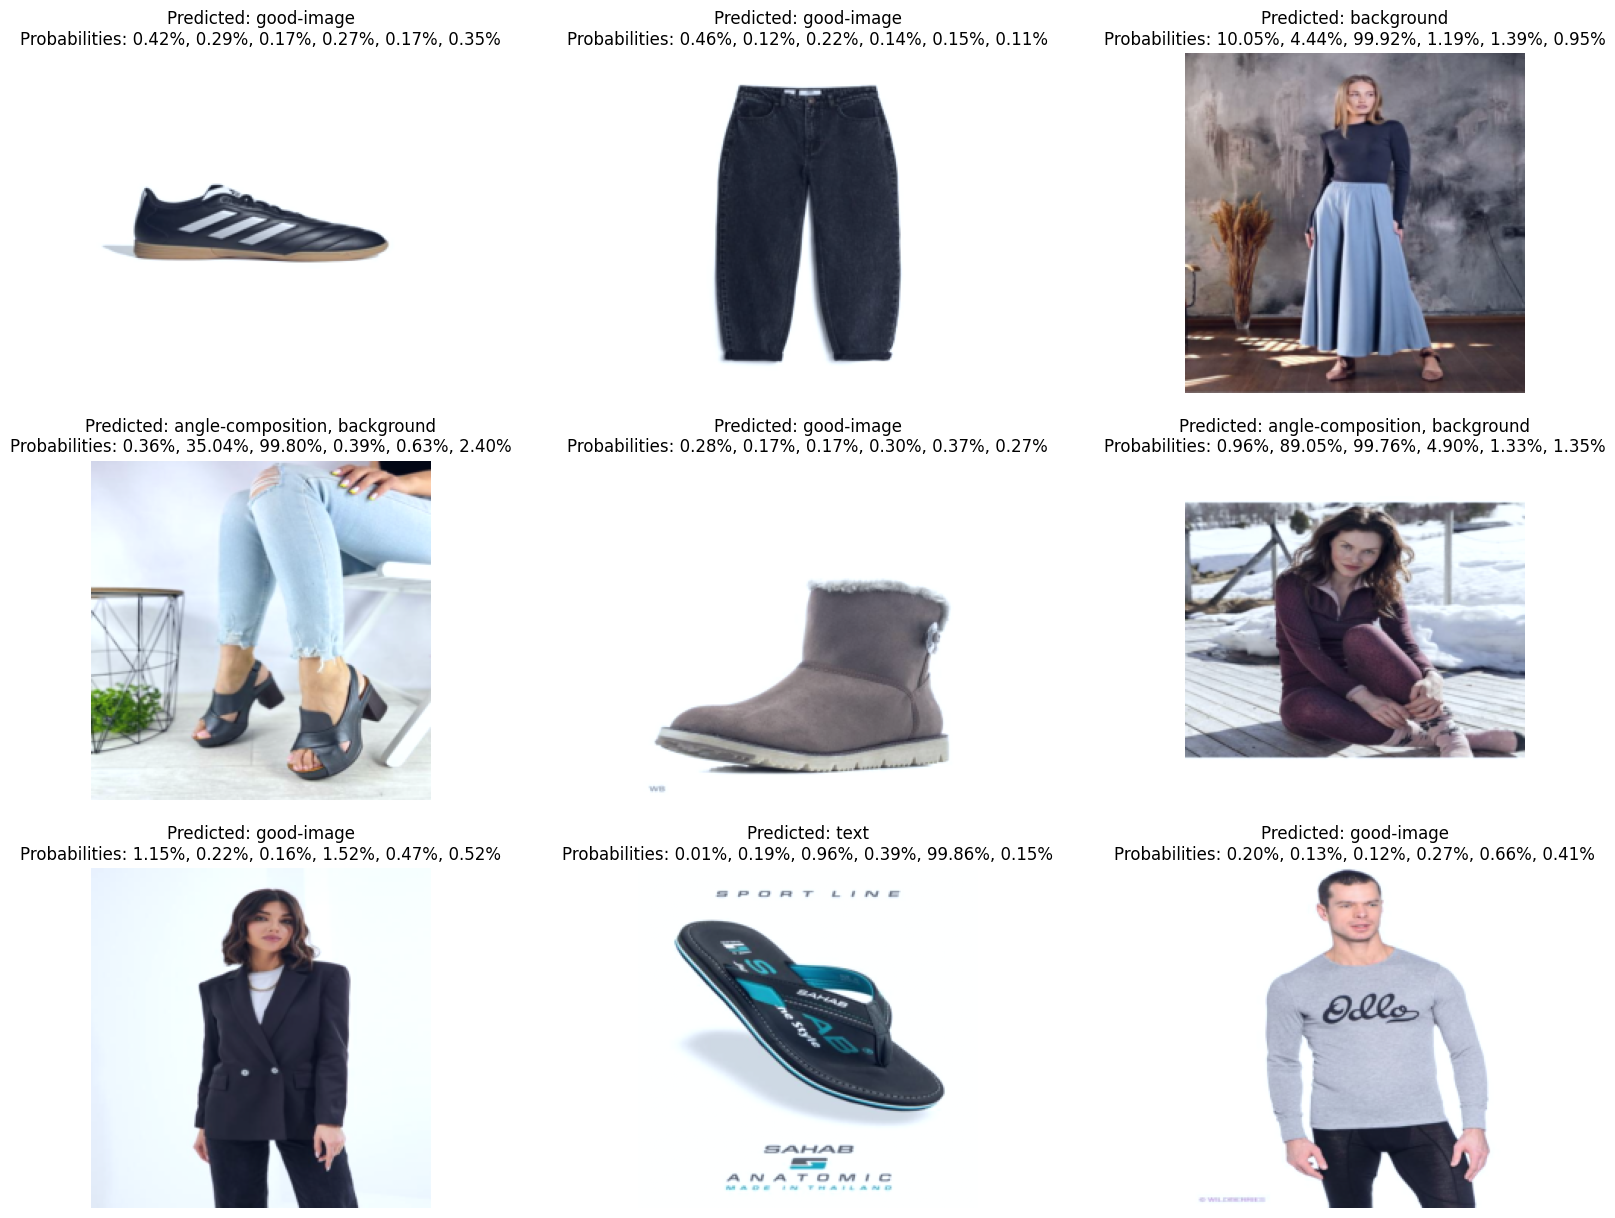

In [ ]:
#@title Визуализация предсказаний

def visualize_predictions(num_images=5):
    plt.figure(figsize=(20, 5 * num_images // 3))
    with torch.no_grad():
        for i in range(num_images):
            random_index = random.randint(0, len(test_dataset) - 1)
            image, _ = test_dataset[random_index]
            image = image.to(DEVICE)
            image = image.unsqueeze(0)

            outputs = best_model(image)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.2).float()
            predicted_labels = [CLASSES[j] for j in range(len(CLASSES)) if preds[0][j] == 1]
            predicted_probs = [f"{probs[0][j].item():.2%}" for j in range(len(CLASSES))]

            # Если модель не предсказывает никаких дефектов
            if not predicted_labels:
                predicted_labels = ['good-image']

            # Отменяем нормализацию
            mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
            std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)
            image = image * std[:, None, None, None] + mean[:, None, None, None]

            plt.subplot(num_images // 3, num_images // 3, i + 1)
            plt.imshow(image[0].cpu().permute(1, 2, 0).numpy())
            plt.title(f"Predicted: {', '.join(predicted_labels)}\nProbabilities: {', '.join(predicted_probs)}")
            plt.axis('off')
    plt.show()


visualize_predictions(num_images=9)

## Если меток нет:

In [ ]:
#@title requirements.txt

!pip install efficientnet_pytorch wget pytorch_lightning

In [ ]:
#@title Импорт библиотек

import os
import wget
import zipfile
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, hamming_loss, roc_curve, auc
import pytorch_lightning as pl
import requests
import random

In [ ]:
#@title Глобальные параметры

MODEL_URL = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/iy45_PHU_Aaglg'
MODEL_PATH = "image_quality-epoch=05-val_loss=0.09.ckpt"

DATA_URL = "https://ml.gan4x4.ru/wb/quality/5000/student_5000.zip" # ВСТАВЬТЕ ВАШУ ССЫЛКУ СЮДА!
ZIP_NAME = "student_5000.zip" # НЕОБХОДИМО ПРОПИСАТЬ ТОЧНОЕ НАИМЕНОВАНИЕ ZIP ФАЙЛА

DATA_DIR = "WB_Images"

IMAGE_DIR = os.path.join(DATA_DIR, "5000", "images") # ТУТ НЕОБХОДИМО НАПИСАТЬ ПУТЬ К ИЗОБРАЖЕНИЯМ

CLASSES = ['untidy', 'angle-composition', 'background', 'crop', 'text', 'multiple-objects']
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title Функции

class ImageQualityDataset(Dataset):
    def __init__(self, image_ids, image_dir, transform=None):
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, str(self.image_ids[idx]) + '.jpg')
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor([0])  # Возвращаем фиктивную метку

class ImageQualityModule(pl.LightningModule):
    def __init__(self, num_classes=len(CLASSES)):
        super(ImageQualityModule, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b4')
        num_ftrs = self.model._fc.in_features
        self.model._fc = torch.nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.BCEWithLogitsLoss()(outputs, labels.float())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.BCEWithLogitsLoss()(outputs, labels.float())
        self.log("val_loss", loss)
        return loss

# Функция для загрузки и распаковки данных
def load_data():
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR, exist_ok=True)
    wget.download(DATA_URL, out=DATA_DIR)

    with zipfile.ZipFile(
        os.path.join(DATA_DIR, ZIP_NAME),
        'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

    image_ids = [f[:-4] for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')]
    return image_ids

In [ ]:
#@title Загрузка данных

image_ids = load_data()

In [ ]:
# Преобразования
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
#@title Датасет и DataLoader

test_dataset = ImageQualityDataset(image_ids, IMAGE_DIR, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
#@title Загрузка модели

# Отправляем GET-запрос и получаем ответ
response = requests.get(MODEL_URL, stream=True)

# Проверяем статус ответа
if response.status_code == 200:
    # Открываем файл для записи
    with open(MODEL_PATH, 'wb') as file:
        # Читаем ответ по частям и записываем в файл
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
else:
    print(f"Ошибка при скачивании: {response.status_code}")

print(f"Файл успешно скачан и сохранен в {MODEL_PATH}")

checkpoint_path = MODEL_PATH

best_model = ImageQualityModule.load_from_checkpoint(checkpoint_path=checkpoint_path)
best_model.eval()

Файл успешно скачан и сохранен в image_quality-epoch=05-val_loss=0.09.ckpt
Loaded pretrained weights for efficientnet-b4


ImageQualityModule(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSame

In [ ]:
#@title Тестирование модели

all_preds = []
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(DEVICE)
        outputs = best_model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        all_preds.append(preds)
        all_probs.append(probs)

all_preds = torch.cat(all_preds).cpu().numpy()
all_probs = torch.cat(all_probs).cpu().numpy()

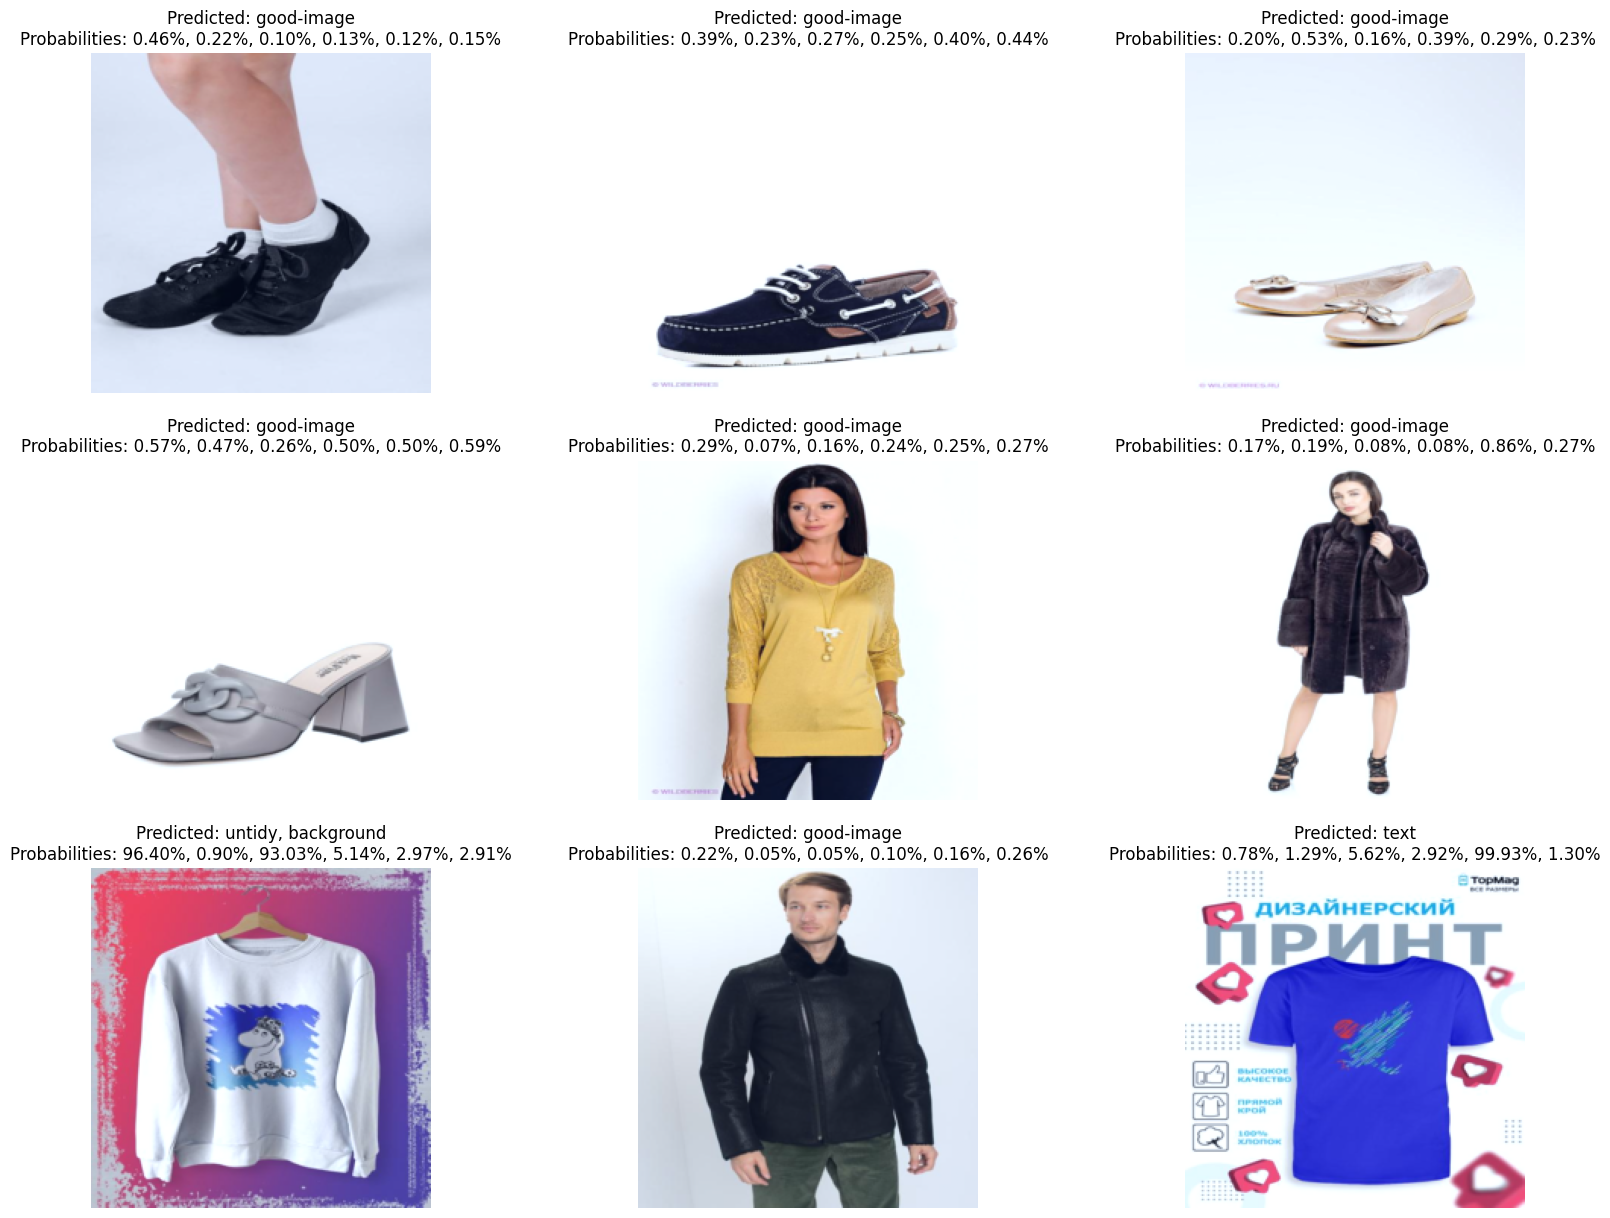

In [ ]:
#@title Визуализация предсказаний

def visualize_predictions(num_images=5):
    plt.figure(figsize=(20, 5 * num_images // 3))
    with torch.no_grad():
        for i in range(num_images):
            random_index = random.randint(0, len(test_dataset) - 1)
            image, _ = test_dataset[random_index]
            image = image.to(DEVICE)
            image = image.unsqueeze(0)

            outputs = best_model(image)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.2).float()
            predicted_labels = [CLASSES[j] for j in range(len(CLASSES)) if preds[0][j] == 1]
            predicted_probs = [f"{probs[0][j].item():.2%}" for j in range(len(CLASSES))]

            # Если модель не предсказывает никаких дефектов
            if not predicted_labels:
                predicted_labels = ['good-image']

            # Отменяем нормализацию
            mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
            std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)
            image = image * std[:, None, None, None] + mean[:, None, None, None]

            plt.subplot(num_images // 3, num_images // 3, i + 1)
            plt.imshow(image[0].cpu().permute(1, 2, 0).numpy())
            plt.title(f"Predicted: {', '.join(predicted_labels)}\nProbabilities: {', '.join(predicted_probs)}")
            plt.axis('off')
    plt.show()


visualize_predictions(num_images=9)